In [ ]:
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt, decimate
from scipy.fft import fft, fftfreq
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [ ]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

def plot_range(ts_start: str, ts_end: str):
    pack = get_range(ts_start, ts_end)
    df = pack["df"]

    # processing
    df = df - df.mean()
    df = np.abs(df)

    low, high = np.percentile(df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    fig = plt.figure(figsize=(12, 16))
    ax = plt.axes()

    im = ax.imshow(df, aspect='auto', interpolation='none', norm=norm)

    ax.set_ylabel("time")
    ax.set_xlabel("space [m]")

    # Colorbar
    cax = fig.add_axes([
        ax.get_position().x1 + 0.06,
        ax.get_position().y0,
        0.02,
        ax.get_position().height
    ])
    plt.colorbar(im, cax=cax)

    # Axis ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))

    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)

    plt.show()
    
def frequency_analysis(ts_start: str, ts_end: str, lowcut=None, highcut=None, downsample_factor=None):
    pack = get_range(ts_start, ts_end)
    data = pack['data']
    dt = pack['dt']
    dx = pack['dx']
    
    # Preprocess data
    processed = preprocess_signal(data, dt, lowcut=lowcut, highcut=highcut, downsample_factor=downsample_factor)
    
    # Number of samples and channels
    n_samples, n_channels = processed.shape
    
    # Frequency axis
    freqs = fftfreq(n_samples, dt)
    
    # FFT for each channel
    fft_magnitudes = np.abs(fft(processed, axis=0))
    
    return freqs, fft_magnitudes, processed
    
def preprocess_signal(data, dt, lowcut=None, highcut=None, downsample_factor=None, standardize=True):
    processed = data.copy()
    
    # Bandpass filter
    if lowcut or highcut:
        nyq = 0.5 / dt
        low = lowcut / nyq if lowcut else None
        high = highcut / nyq if highcut else None
        
        if low and high:
            b, a = butter(4, [low, high], btype='band')
        elif low:
            b, a = butter(4, low, btype='high')
        elif high:
            b, a = butter(4, high, btype='low')
        processed = filtfilt(b, a, processed, axis=0)
    
    # Downsample
    if downsample_factor:
        processed = decimate(processed, downsample_factor, axis=0)
    
    # Standardization
    if standardize:
        processed = (processed - np.mean(processed, axis=0)) / np.std(processed, axis=0)
    
    return processed

def plot_fft(freqs, fft_magnitudes, channels=None, max_freq=None):
    import matplotlib.pyplot as plt
    n_channels = fft_magnitudes.shape[1]
    
    if channels is None:
        channels = range(n_channels)
    
    plt.figure(figsize=(12, 6))
    for ch in channels:
        mag = fft_magnitudes[:, ch]
        if max_freq:
            mask = freqs <= max_freq
            plt.plot(freqs[mask], mag[mask], label=f'Channel {ch}')
        else:
            plt.plot(freqs, mag, label=f'Channel {ch}')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title('Frequency Analysis')
    plt.legend()
    plt.show()
    
def remove_static_background(df, window_size=50):
    background = df.rolling(window=window_size, axis=0, min_periods=1, center=True).median()
    return df - background

def enhance_contrast(df):
    arr = np.abs(df.values)
    p1, p99 = np.percentile(arr, [1, 99])
    arr = (arr - p1) / (p99 - p1 + 1e-10)
    arr = np.clip(arr, 0, 1)
    return arr

def extract_moving_objects(df, dt, window_size=50):
    df_moving = remove_static_background(df, window_size=window_size)
    arr = enhance_contrast(df_moving)
    return pd.DataFrame(arr, index=df.index, columns=df.columns)

def plot_moving_objects(ts_start, ts_end):
    pack = get_range(ts_start, ts_end)
    df = pack['df']
    dt = pack['dt']

    df_moving = extract_moving_objects(df, dt)

    fig, ax = plt.subplots(figsize=(12, 16))
    im = ax.imshow(np.abs(df_moving), aspect='auto', interpolation='none', cmap='viridis')
    plt.colorbar(im, ax=ax, label='Amplitude')
    ax.set_xlabel('Space [m]')
    ax.set_ylabel('Time')
    plt.show()
    
def estimate_velocities(df_moving, dt, dx, low_thresh=0.05, high_thresh=0.2):
    arr = df_moving.values
    edges = canny(arr, sigma=1, low_threshold=low_thresh, high_threshold=high_thresh)
    h, theta, d = hough_line(edges)
    
    velocities = []
    for _, angle, _ in zip(*hough_line_peaks(h, theta, d)):
        slope = np.tan(angle)
        v = slope * dx / dt
        velocities.append(v)
    
    # Optionally: group velocities to remove duplicates
    velocities = np.array(velocities)
    if len(velocities) > 0:
        grouped = []
        while len(velocities) > 0:
            ref = velocities[0]
            group = velocities[np.abs(velocities - ref) < 0.2]  # group similar slopes
            grouped.append(np.mean(group))
            velocities = np.delete(velocities, np.where(np.abs(velocities - ref) < 0.2))
        velocities = grouped
    return velocities

def analyze_segment(ts_start, ts_end):
    results = []
    start_dt = datetime.datetime.strptime("2024-05-07 " + start, "%Y-%m-%d %H%M%S")
    end_dt = start_dt + datetime.timedelta(minutes=segment_length_minutes)
    ts_start = start_dt.strftime("%H:%M:%S")
    ts_end = end_dt.strftime("%H:%M:%S")
    
    pack = get_range(ts_start, ts_end)
    data = pack["data"]
    df = pack["df"]
    dt = pack["dt"]
    dx = pack["dx"]
    
    # Preprocess
    data_proc = preprocess_signal(data, dt)
    
    # FFT
    freqs, fft_mags = frequency_analysis(data_proc, dt)
    
    # Moving objects
    df_moving = extract_moving_objects(df, dt)
    
    # Velocity
    velocities = estimate_velocities(df_moving, dt, dx)
    
    return {
        "ts_start": ts_start,
        "ts_end": ts_end,
        "freqs": freqs,
        "fft_mags": fft_mags,
        "df_moving": df_moving,
        "velocities": velocities
    }

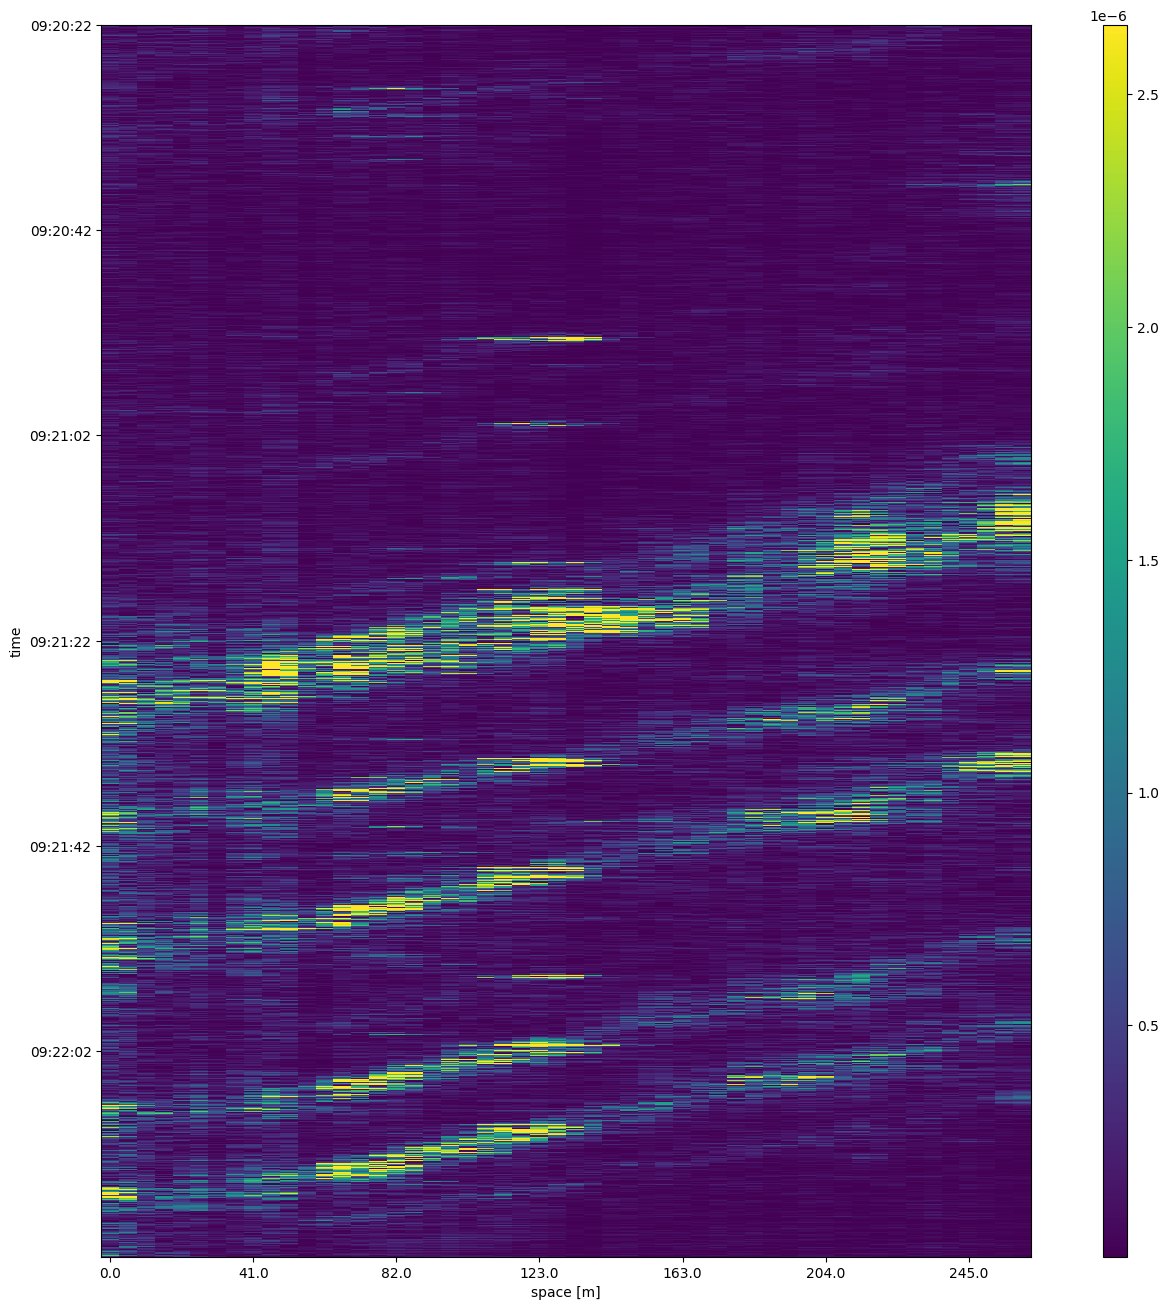

In [37]:
plot_range(range1[0], range1[1])
#plot_range(range2[0], range2[1])
#plot_range(range3[0], range3[1])

In [46]:

pack = get_range(range1[0], range1[1])
df = pack['df']
dt = pack['dt']
dx = pack['dx']

# Extract moving objects
df_moving = extract_moving_objects(df, dt)

#plot_moving_objects(range1[0], range1[1])

# Estimate velocities
velocities = estimate_velocities(df_moving, dt, dx)
print("Estimated velocities (m/s):", velocities)



Estimated velocities (m/s): []
